## Scraper w/ BioPython

Module Description:

The BioWebScraper function queries PubMed for the keyterms provided, along with a date range provided. Currently, these values are hard-coded, but can easily be implemented into a command prompt, interactive Python compiler (like Spyder), or a py-based GUI (Like PyQT).

The function can be called elsewhere in the Jupyter Notebook, but does not return any values. Scraping takes anywhere between 30 minutes to an hour to complete, depending on how busy the PubMed server is and the breadth of the query.

For ease of implementation, it is recommended to call the "scraper.py" script thru a main python script. An example of this main call is shown below. Some possible implementations for future use include:
- Development of a GUI class, to format a graphical interface for the data scraped from PubMed
- Development of a pandas class, to allow the user to view the pre-processed results and further refine the data to articles that are specifically of interest
- Development of a database tool, to host the post-processed results after processing thru pandas
- Development of deep learning / LLM / machine learning to extract key information out of the article (beyond the scope of this practicum project, but certainly an avenue for further development).

BioWebScraper makes use of the following imported libraries:
* sys: Python system library for system functions
* logging: Logging library for debugging purposes
* gc: Garbage collection library to help clean up memory
* csv: CSV parsing library for read/writing to CSV file
* datetime: Date and time library. Used to generate a file name for the scraped data
* requests: HTML interface library for connecting to a given URL
* bs4: Beautiful Soup library, for scraping HTML/XML data
* regex: Regular expression library, for parsing regex text search/replace functions
* Bio: Biopython, with the Entrez module as the primary interface to the PubMed database
* tqmd: Progress meter for the main scraping loop

The basic structure of the code is follows:
* Create and open CSV file
* Create and open log
* Connect to PubMed via API key and search for the given keyword and date range
* Loop over the query results and parse into the CSV file. The pipe character "|" is used as the delimiter for this code, as the comma shows up in a lot of the Author and Abstract queries and causes issues for text parsing
* Write each entry to the CSV file if it meets the criteria for Author/Article Title. Bypasses writing entries that do not fit this criteria
* Close the CSV file and report complete.

The output CSV file is returned with the following headers:
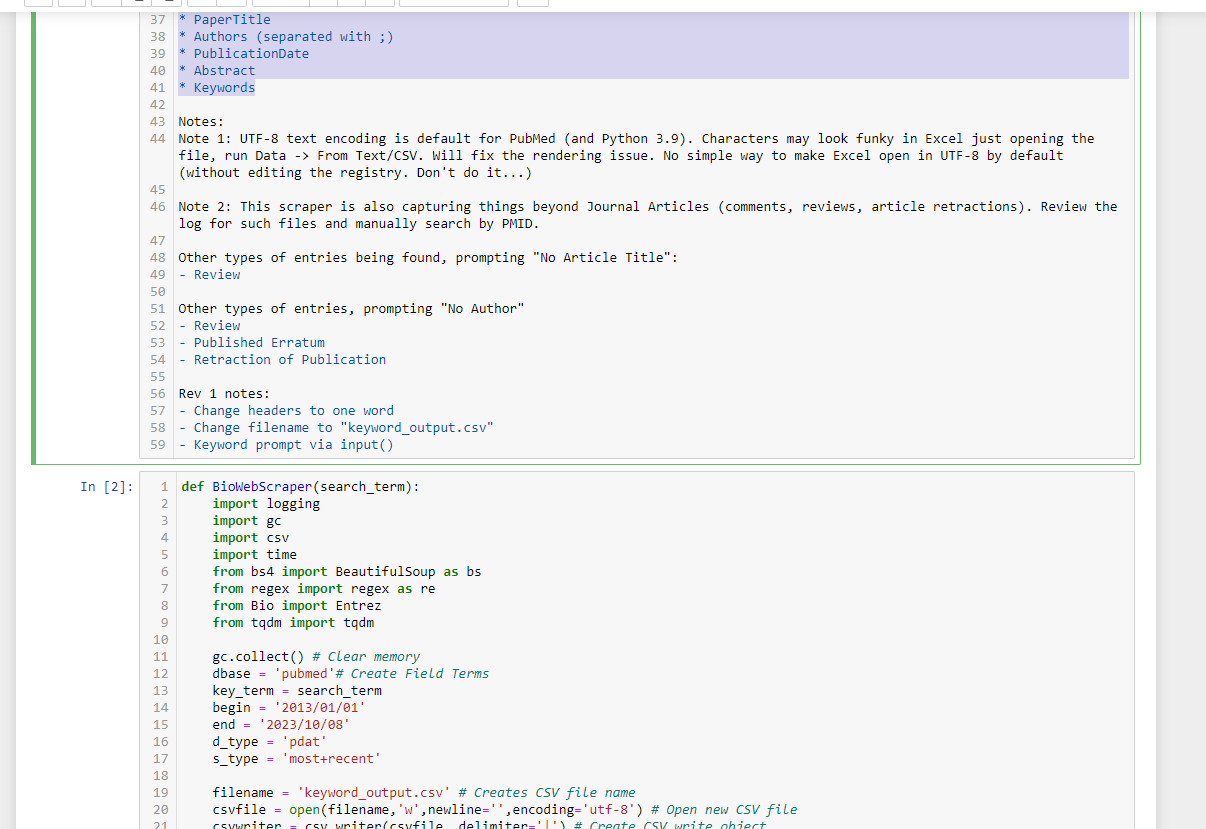* PMID (PubMed ID)
* PaperTitle
* Authors (separated with ;)
* PublicationDate
* Abstract
* Keywords

Notes:
Note 1: UTF-8 text encoding is default for PubMed (and Python 3.9). Characters may look funky in Excel just opening the file, run Data -> From Text/CSV. Will fix the rendering issue. No simple way to make Excel open in UTF-8 by default (without editing the registry. Don't do it...)

Note 2: This scraper is also capturing things beyond Journal Articles (comments, reviews, article retractions). Review the log for such files and manually search by PMID.

Other types of entries being found, prompting "No Article Title":
- Review

Other types of entries, prompting "No Author"
- Review
- Published Erratum
- Retraction of Publication

Rev 1 notes:
- Change headers to one word
- Change filename to "keyword_output.csv"
- Keyword prompt via input()

In [2]:
def BioWebScraper(search_term):
    import logging
    import gc
    import csv
    import time
    from bs4 import BeautifulSoup as bs
    from regex import regex as re
    from Bio import Entrez
    from tqdm import tqdm
    
    gc.collect() # Clear memory
    dbase = 'pubmed'# Create Field Terms
    key_term = search_term
    begin = '2013/01/01'
    end = '2023/10/08'
    d_type = 'pdat'
    s_type = 'most+recent'
    
    filename = 'keyword_output.csv' # Creates CSV file name
    csvfile = open(filename,'w',newline='',encoding='utf-8') # Open new CSV file 
    csvwriter = csv.writer(csvfile, delimiter='|') # Create CSV write object
    header = ['PMID','PaperTitle','Authors','PublicationDate','Abstract', 'Keywords']
    csvwriter.writerow(header) #Create header line

    #Get UIDs from Pubmed
    Entrez.email = "erin.schwartz@uth.tmc.edu"
    Entrez.api_key = '581e6721362b9fbc9ced2c8aee342e87dc09'
    Entrez.sleep_between_tries = 30
    Entrez.max_tries = 10
    # Esearch for UIDs
    print('Searching...')
    handle = Entrez.esearch(db=dbase, term=key_term,mindate=begin,maxdate=end,datetype=d_type)
    records = Entrez.read(handle)
    count = records['Count']
    print(count+" records found. Filtering for journals and scraping...")
    handle = Entrez.esearch(db=dbase, term=key_term,retmax=count,mindate=begin,maxdate=end,datetype=d_type,sort=s_type)
    records = Entrez.read(handle)
    
    #Parse XML into the CSV
    for record in tqdm(records['IdList']):
        try:
            entry = Entrez.efetch(db='pubmed',
                                  id=record,
                                  retmode='xml')
        except:
            try:
                time.sleep(10) # Pad 10 second wait if HTML reject to not spam PubMed
                entry = Entrez.efetch(db='pubmed',
                                      id=record,
                                      retmode='xml')
            except: 
                time.sleep(30) # Pad 30 second wait if HTML reject to not spam PubMed
                entry = Entrez.efetch(db='pubmed',
                                      id=record,
                                      retmode='xml')
        try:
            result = entry.read()
        except:
            try:
                time.sleep(10)
                entry = Entrez.efetch(db='pubmed',
                                      id=record,
                                      retmode='xml')
                result = entry.read()
            except:
                time.sleep(30)
                entry = Entrez.efetch(db='pubmed',
                                      id=record,
                                      retmode='xml')
                result = entry.read() 
        soup = bs(result,"xml")
        
        # Get Paper Title
        if soup.find("ArticleTitle"):
            article_title = soup.find("ArticleTitle").get_text()
        else:
            article_title = 'No article title found.'
            logging.info('No article title. Not a journal/article. PMID: %s',soup.find('PMID').get_text())
            continue
        
        # Get Authors
        namelist = ''
        try:
            authors = soup.find("AuthorList").find_all("Author",ValidYN="Y")
        except:
            logging.info('No authors listed. Not a journal/article. PMID: %s',soup.find('PMID').get_text())
            continue
        for author in authors:
            try:
                if author.LastName is None:
                    lastName = None
                else:
                    lastName = author.LastName.get_text()
                if author.ForeName is None:
                    foreName = None
                else:
                    foreName = author.ForeName.get_text()
                if lastName and foreName:
                    name = f"{lastName}, {foreName}"
                elif lastName and not foreName:
                    name = f"{lastName}"
                elif not lastName and foreName:
                    name = f"{foreName}"
            except:
                name = 'Author issue'
                logging.info('Author issue, review this article. PMID: %s',soup.find('PMID').get_text())
            namelist = f"{namelist}{name}; "

        # Get Publication Date
        date_holder = soup.find("ArticleDate")
        if date_holder is None:
            continue
        else:
            pub_date = soup.find("ArticleDate").get_text()
        # Fix date spacing
        if re.fullmatch(r'(\d{4})(.{3})(\d{2})',pub_date):
            pub_date = re.sub(r'(\d{4})(.{3})(\d{2})',r'\1 \2 \3',pub_date)
        elif re.fullmatch(r'(\d{6})',pub_date):
            pub_date = re.sub(r'(\d{4})(\d{2})',r'\1 \2',pub_date)
        elif re.fullmatch(r'(\d{4})(.{3})',pub_date):
            pub_date = re.sub(r'(\d{4})(.{3})',r'\1 \2',pub_date)
        elif re.fullmatch(r'(\d{4})(\d{2})(\d{2})',pub_date):
            pub_date = re.sub(r'(\d{4})(\d{2})(\d{2})',r'\1 \2 \3',pub_date)
        
        # Get Abstract
        if soup.find("AbstractText"):
            abstract = soup.find("AbstractText").get_text()
        else:
            abstract = 'No abstract.'
            logging.info('No abstract. PMID: %s',soup.find('PMID').get_text())
        
        # Get PMID
        if soup.find("PMID"):
            pmid = soup.find("PMID").get_text()
        
        # Get Keywords
        keylist = ''
        try:
            keywords = soup.find("KeywordList").find_all("Keyword")
        except:
            logging.info('No keywords listed. Not a journal/article. PMID: %s',soup.find('PMID').get_text())
            continue
        for keyword in keywords:
            try:
                kwd = keyword.get_text()
            except:
                kwd = 'Keyword issue'
                logging.info('Kwd issue, review this article. PMID: %s',soup.find('PMID').get_text())
            keylist = f"{keylist}{kwd}; "
        
        # Create CSV Entry
        journal = [pmid,article_title,namelist,pub_date,abstract, keylist]
        csvwriter.writerow(journal)
        # Add some wait time
        delay = 0.200 # 200ms delay time
        time.sleep(delay)
    
    # Close file
    csvfile.close()

    print('Scraping Complete')
    return filename 
    

## Main

Example of how to run the scraper module. This can be executed in Python via command prompt, in an interactive shell (such as Spyder), or thru a GUI. Additional features can be implemented as such.

In [ ]:
BioWebScraper("((public health) AND (texas) AND (cancer)) AND (evidence-based interventions)")


<?xml version="1.0" encoding="utf-8"?>
<!DOCTYPE PubmedArticleSet PUBLIC "-//NLM//DTD PubMedArticle, 1st January 2019//EN" "https://dtd.nlm.nih.gov/ncbi/pubmed/out/pubmed_190101.dtd">
<PubmedArticleSet>
 <PubmedArticle>
  <MedlineCitation Owner="NLM" Status="PubMed-not-MEDLINE">
   <PMID Version="1">
    35463100
   </PMID>
   <DateRevised>
    <Year>
     2022
    </Year>
    <Month>
     04
    </Month>
    <Day>
     29
    </Day>
   </DateRevised>
   <Article PubModel="Print-Electronic">
    <Journal>
     <ISSN IssnType="Print">
      0970-1915
     </ISSN>
     <JournalIssue CitedMedium="Print">
      <Volume>
       37
      </Volume>
      <Issue>
       2
      </Issue>
      <PubDate>
       <Year>
        2022
       </Year>
       <Month>
        Apr
       </Month>
      </PubDate>
     </JournalIssue>
     <Title>
      Indian journal of clinical biochemistry : IJCB
     </Title>
     <ISOAbbreviation>
      Indian J Clin Biochem
     </ISOAbbreviation>
    </Journal>
   

AttributeError: 'NoneType' object has no attribute 'get_text'